In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install gputil
!pip install psutil
!pip install humanize

     |████████████████████████████████| 2.2MB 8.2MB/s 
     |████████████████████████████████| 870kB 41.1MB/s 
     |████████████████████████████████| 3.3MB 41.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=75b77c3af9917e3a66c8fe60d77ff2f970a85ef4c6dbd93ad06c94b157d18bc4
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=9c6b942d87b0753b6c0d1e86b974f76e40618b92a883cf41c780f2d77a460b13
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [3]:
import torch, logging, os, re, random, pickle, logging
from torch.utils.data import (
    TensorDataset, 
    DataLoader, 
    Subset, 
    RandomSampler, 
    SequentialSampler, 
    Dataset
)
import numpy as np, torch.nn as nn, pandas as pd,\
torch.nn.functional as F, matplotlib.pyplot as plt,\
seaborn as sn
from time import time, sleep
from models import BertForRE
from torch.optim import Adam
from string import punctuation
from sklearn.metrics import confusion_matrix
from torch.utils.data import (
    TensorDataset, 
    DataLoader, 
    Subset, 
    RandomSampler, 
    SequentialSampler, 
    Dataset
)
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    precision_recall_fscore_support
)
from transformers import (
    BertTokenizer, 
    AdamW, 
    get_linear_schedule_with_warmup
)

In [4]:
def download_dirs(dirlist):
    from google.colab import files
    for dirname in dirlist:
        for filename in os.listdir(dirname):
            filename = os.path.join(dirname, filename)
            files.download(filename)

def get_dataLoader(dataset, splits, batch_sizes, shuffle_indices, **kwargs):
    n_samples = len(dataset)
    indices = list(range(n_samples))
    if shuffle_indices:
        np.random.shuffle(indices)
    split_index = int(n_samples*splits[0])
    train_indices = indices[:split_index]
    valid_indices = indices[split_index:]
    train_dataset = Subset(dataset, train_indices)
    valid_dataset = Subset(dataset, valid_indices)
    train_loader = DataLoader(
        train_dataset, shuffle=True, batch_size=batch_sizes[0], **kwargs
    )
    valid_loader = DataLoader(
        valid_dataset, shuffle=False, batch_size=batch_sizes[1], **kwargs
    )
    return train_loader, valid_loader

def fix_seed(seed_value, random_lib=False, numpy_lib=False, torch_lib=False):
    if random_lib:
        random.seed(seed_value)
    if numpy_lib:
        np.random.seed(seed_value)
    if torch_lib:
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

def setup_logger(name, format=None, level=logging.DEBUG, handlers=None, log_file='default.log'):
    logging.basicConfig(
        level=level, 
        format=format if format else '%(asctime)s [%(levelname)s] %(message)s',
        handlers=handlers if handlers else [
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(name)
    logger.setLevel(level)

def cal_accuracy(pred_labels, true_labels):
    _, pred_labels = pred_labels.max(dim=1)
    true_labels = true_labels.view(-1)
    return torch.sum(pred_labels == true_labels).item() / true_labels.size()[0]


def get_df(fliepath, label_dict=None, n_phrases=0):
    rep = {'<e1>': ' <E1> ', '<e2>': ' <E2> ', '</e1>': ' </E1> ', '</e2>': ' </E2> '}
    rep = dict((re.escape(k), v) for k, v in rep.items())
    pattern = re.compile("|".join(rep.keys()))
    with open(fliepath, 'r') as train_file:
        phrases = []
        labels = []
        for line in train_file.readlines():
            line = line.strip().split('\t')
            if len(line)>1:
                phrases.append(pattern.sub(lambda m: rep[re.escape(m.group(0))], line[1].strip('"')))
            elif not line[0].startswith('Comment') and line[0]:
                labels.append(line[0].split('(')[0])
    if not label_dict:
        label_set = set(labels[:n_phrases])-{'Other'}
        label_dict = dict(zip(label_set, range(len(label_set))))
        label_dict['Other'] = len(label_set)
    df = pd.DataFrame(list(zip(phrases[:n_phrases], labels[:n_phrases])), columns=['phrase', 'label'])
    df['label_id'] = df.label.apply(lambda x: label_dict[x])
    df['phrase_len'] = df.phrase.apply(lambda x: len(x.split()))
    return df, label_dict

In [5]:
class SelfDataset(Dataset):
    def __init__(self, input_df, batch_size, tokenizer=None, special_tokens=['<E1>', '</E1>', '<E2>', '</E2>']):
        if tokenizer:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = BertTokenizer.from_pretrained(
                'bert-base-uncased',
                do_lower_case = True,
                additional_special_tokens = special_tokens
            )
        self.inputs = list(input_df.phrase.values)
        self.special_token_ids = self.tokenizer.convert_tokens_to_ids(['<E1>', '</E1>', '<E2>', '</E2>'])
        self.labels = torch.as_tensor(
            input_df.label_id.values, dtype = torch.long
        )
        self.batch_size = batch_size
        self.inputs_size = len(self.inputs)
    
    def __getitem__(self, item):
        encoded_input = self.tokenizer(
            self.inputs[
                item*self.batch_size:min(item*self.batch_size+self.batch_size, self.inputs_size)
            ],
            add_special_tokens = True,
            padding='longest',
            return_attention_mask = True,
            return_tensors = 'pt',
        )
        special_indices = torch.as_tensor(np.where(
            np.isin(encoded_input.input_ids.numpy(), self.special_token_ids)
        )[1]).view(encoded_input.input_ids.size(0), 2, 2)
        return (
            encoded_input.input_ids, 
            encoded_input.attention_mask, 
            self.labels[
                item*self.batch_size:min(item*self.batch_size+self.batch_size, self.inputs_size)
            ],
            special_indices
        )
    
    def __len__(self):
        return int(np.ceil(self.inputs_size/self.batch_size))

In [6]:
class TrainTest():
    def __init__(self, model, optimizer, scheduler, criterion, logger=None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.logger = logger
        self.tr_metrics = {
            'train_loss':[],
            'train_accuracy':[],
            'valid_loss':[],
            'valid_accuracy':[],
        }
        
    def train(
        self, train_loader, valid_loader, 
        num_epochs, device, eval_interval, 
        clip=None, model_path=None, save_per_epoch=None,
        results_path=None, defaults=None, **kwargs
    ):
        total_itrs = num_epochs*len(train_loader)
        num_tr, total_tr_loss, itr = 0, 0, 0
        self.model.train()
        for epoch in range(num_epochs):
            for i, (input_ids, att_masks, input_labels, special_indices) in enumerate(train_loader):
                input_ids = input_ids.squeeze(0).to(device)
                att_masks = att_masks.squeeze(0).to(device)
                input_labels = input_labels.squeeze(0).to(device)
                special_indices = special_indices.squeeze(0).to(device)
                self.optimizer.zero_grad()
                output = self.model(
                    input_ids,
                    attention_mask=att_masks,
                    firsts=special_indices[:, 0, :],
                    seconds=special_indices[:, 1, :],
                    token_type_ids=None
                )
                tr_loss = self.criterion(output, input_labels.view(-1))
                # nn.utils.clip_grad_norm_(model.parameters(), clip)
                if self.logger:
                    self.logger.info(f'Training: {itr}/{total_itrs} -- loss: {tr_loss.item()}')
                tr_loss.backward()
                self.optimizer.step()
                self.scheduler.step()
                num_tr += 1
                total_tr_loss += tr_loss
                if itr % eval_interval == 0 or itr+1 == total_itrs:
                    self.tr_metrics['train_loss'].append(total_tr_loss.cpu().item()/num_tr)
                    tr_accuracy = cal_accuracy(output, input_labels)
                    self.tr_metrics['train_accuracy'].append(tr_accuracy)
                    num_tr, total_tr_loss = 0, 0
                    val_loss = 0
                    self.model.eval()
                    val_accuracy = []
                    with torch.no_grad():
                        for val_ids, val_masks, val_labels, val_tokens in valid_loader:
                            val_ids = val_ids.squeeze(0).to(device)
                            val_masks = val_masks.squeeze(0).to(device)
                            val_labels = val_labels.squeeze(0).to(device)
                            val_tokens = val_tokens.squeeze(0).to(device)
                            val_output = self.model(
                                val_ids,
                                attention_mask=val_masks,
                                firsts=val_tokens[:, 0, :],
                                seconds=val_tokens[:, 1, :],
                                token_type_ids=None
                            )
                            val_loss += self.criterion(val_output, val_labels.view(-1))
                            val_accuracy.append(cal_accuracy(val_output, val_labels))
                    self.tr_metrics['valid_accuracy'].append(np.mean(val_accuracy))
                    self.tr_metrics['valid_loss'].append(val_loss.cpu().item()/len(valid_loader))
                    self.model.train()
                    if self.logger:
                        self.logger.info(f'Training: iteration: {itr}/{total_itrs} -- epoch: {epoch} -- '
                        f' train_loss: {self.tr_metrics["train_loss"][-1]:.3f} -- train_accuracy: {self.tr_metrics["train_accuracy"][-1]:.2f}'
                        f' valid_loss: {self.tr_metrics["valid_loss"][-1]:.3f} -- valid_accuracy: {self.tr_metrics["valid_accuracy"][-1]:.2f}')
                itr += 1
            if model_path and results_path and ((epoch+1) % save_per_epoch == 0) and epoch != 0:
                self.save_model(epoch+1, model_path, f'{epoch+1}_epochs_train')
                self.save_results(results_path, f'{epoch+1}_epochs_train', self.tr_metrics)
        if model_path and results_path:
            self.save_model(epoch+1, model_path, f'{epoch+1}_epochs_last_train')
            self.save_results(results_path, f'{epoch+1}_epochs_last_train', self.tr_metrics)
            
    def save_model(self, epoch, model_path, name):
        model_dir = '/'.join(model_path.split('/')[:-1])
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'loss': self.tr_metrics['valid_loss'][-1],
            }, os.path.join(model_dir, f'model_{name}.pt')
        )
        if self.logger:
            self.logger.info(f'Training: model saved to: {model_dir}/model_{name}.pt')
    
    def save_results(self, results_path, name, results):
        results_dir = '/'.join(results_path.split('/')[:-1])
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        with open(os.path.join(results_dir, f'results_{name}.pkl'), 'wb') as save_file:
            pickle.dump(results, save_file)
        if self.logger:
            self.logger.info(f'Training: results saved to: {results_dir}/resutls_{name}.pkl')

    def test(self, test_loader, device, all_labels, results_path=None, defaults=None):
        test_accuracy, test_true, test_pred = [], [], []
        test_loss = 0
        self.model.eval()
        with torch.no_grad():
            for test_ids, test_masks, test_labels, test_tokens in test_loader:
                test_ids = test_ids.squeeze(0).to(device)
                test_masks = test_masks.squeeze(0).to(device)
                test_labels = test_labels.squeeze(0).to(device)
                test_tokens = test_tokens.squeeze(0).to(device)
                test_output = self.model(
                    test_ids,
                    attention_mask=test_masks,
                    firsts=test_tokens[:, 0, :],
                    seconds=test_tokens[:, 1, :],
                    token_type_ids=None
                )
                test_loss += self.criterion(test_output, test_labels.view(-1))
                test_accuracy.append(cal_accuracy(test_output, test_labels))
                test_true.append(test_labels.cpu())
                test_pred.append(test_output.cpu().max(dim=1)[1])
        test_true = torch.cat(test_true)
        test_pred = torch.cat(test_pred)
        test_loss = test_loss.cpu().item()/len(test_loader)
        test_accuracy = np.mean(test_accuracy)
        prf = precision_recall_fscore_support(
            test_true,
            test_pred,
            labels=all_labels,
            average='weighted'
        )
        confm = confusion_matrix(test_true, test_pred, labels=all_labels)
        self.ts_metrics = {
            'loss':test_loss,
            'accuracy':test_accuracy,
            'precision':prf[0],
            'recall':prf[1],
            'f1_score':prf[2],
            'confusion_matrix':confm
        }
        if self.logger:
            print(f'Testing: test_loss: {test_loss:.3f} -- test_accurcy: {test_accuracy:.2f}')
        if results_path:
            self.save_results(results_path, f'test', self.ts_metrics)


In [7]:
cuda_flag = True if torch.cuda.is_available() else False
lrlast = .001
lrmain = .00001
n_iters = 10000
num_epochs = 10
eval_interval = 40
save_model = True
device = torch.device('cuda' if cuda_flag else 'cpu')
params = {'num_workers': 2, 'pin_memory': True} if cuda_flag else {}
data_splits = [0.85, 0.15]
batch_sizes = [1, 1]
seed = 20214
fix_seed(seed, random_lib=True, numpy_lib=True, torch_lib=True)

# Set path to train and test files

In [ ]:
train_df, train_label_dict = get_df(
    '/content/drive/MyDrive/SemEval2010_task8_all_data/SemEval2010_task8_training/TRAIN_FILE.TXT', 
    n_phrases=7109
)
train_dataset = SelfDataset(train_df, batch_size=64)
train_loader, valid_loader = get_dataLoader(
    train_dataset,
    data_splits,
    batch_sizes,
    shuffle_indices=True, **params
)

test_df, _ = get_df(
    '/content/drive/MyDrive/SemEval2010_task8_all_data/SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT', 
    label_dict=train_label_dict,
    n_phrases=2717
)
test_dataset = SelfDataset(
    test_df, batch_size=64, tokenizer=train_dataset.tokenizer
)
test_loader = DataLoader(
    test_dataset, shuffle=False, batch_size=1, **params
)

print(f'number of epochs: {num_epochs}')
print(f'number of iteration: {num_epochs*len(train_loader)}')
print(f'number of intervals: {num_epochs*len(train_loader)/eval_interval}')

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


number of epochs: 10
number of iteration: 950
number of intervals: 23.75


In [9]:
train_label_dict

{'Message-Topic': 0,
 'Instrument-Agency': 1,
 'Entity-Origin': 2,
 'Component-Whole': 3,
 'Member-Collection': 4,
 'Content-Container': 5,
 'Entity-Destination': 6,
 'Cause-Effect': 7,
 'Product-Producer': 8,
 'Other': 9}

In [ ]:
vocab_file = 'bert-base-uncased'
model = BertForRE(
    vocab_file,
    num_classes=len(train_label_dict),
    fcc_uotput_size=128,
    vocab_size=len(train_dataset.tokenizer)).to(device
)
optimizer = Adam([
    {"params":model.bert.parameters(),"lr": lrmain},
    {"params":model.dropout.parameters(), "lr": lrlast},
    {"params":model.classifier.parameters(), "lr": lrlast},                    
])
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0,
    num_training_steps = num_epochs*len(train_loader)
)
# for param in model.bert.parameters():
#     param.requires_grad = False

open('metrics.log', 'w').close()
logger = setup_logger(name='track_logger', level=logging.INFO, log_file='metrics.log')

In [ ]:
traintest = TrainTest(model, optimizer, scheduler, F.nll_loss, logger)
traintest.train(
    train_loader,
    valid_loader,
    num_epochs,
    device,
    eval_interval,
    model_path='./models/',
    save_per_epoch=4,
    results_path='./results/',
    clip=5
)

/content/bert_net.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_logits = F.log_softmax(logits)
2021-04-11 08:45:26,852 [INFO] Training: 0/950 -- loss: 2.306577444076538
2021-04-11 08:45:29,853 [INFO] Training: iteration: 0/950 -- epoch: 0 --  train_loss: 2.307 -- train_accuracy: 0.14 valid_loss: 2.287 -- valid_accuracy: 0.13
2021-04-11 08:45:30,000 [INFO] Training: 1/950 -- loss: 2.3137013912200928
2021-04-11 08:45:30,419 [INFO] Training: 2/950 -- loss: 2.296905994415283
2021-04-11 08:45:30,867 [INFO] Training: 3/950 -- loss: 2.260308027267456
2021-04-11 08:45:31,286 [INFO] Training: 4/950 -- loss: 2.261209726333618
2021-04-11 08:45:31,689 [INFO] Training: 5/950 -- loss: 2.2826976776123047
2021-04-11 08:45:32,082 [INFO] Training: 6/950 -- loss: 2.2350220680236816
2021-04-11 08:45:32,383 [INFO] Training: 7/950 -- loss: 2.4077308177948
2021-04-11 08:45:32,586 [INFO] Training: 8/950 -- loss: 2.233

In [ ]:
traintest.test(
    test_loader, 
    device, 
    list(train_label_dict.values()),
    results_path='./results/'
)
download_dirs(['./results/'])

/content/bert_net.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_logits = F.log_softmax(logits)
2021-04-11 08:53:44,807 [INFO] Training: results saved to: ./results/resutls_test.pkl


Testing: test_loss: 0.568 -- test_accurcy: 0.82


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
traintest.tr_metrics

{'train_accuracy': [0.140625,
  0.390625,
  0.59375,
  0.625,
  0.703125,
  0.796875,
  0.828125,
  0.796875,
  0.8125,
  0.84375,
  0.78125,
  0.859375,
  0.921875,
  0.9375,
  0.875,
  0.9375,
  0.875,
  0.9375,
  0.953125,
  0.953125,
  0.953125,
  0.984375,
  0.9375,
  0.96875,
  0.953125],
 'train_loss': [2.306577444076538,
  2.179328727722168,
  1.7631929397583008,
  1.2584355354309082,
  0.8894618034362793,
  0.7586104393005371,
  0.614453649520874,
  0.5530331611633301,
  0.4740333557128906,
  0.4192520618438721,
  0.3876132249832153,
  0.34641740322113035,
  0.3361485004425049,
  0.2794961929321289,
  0.29177820682525635,
  0.2410573959350586,
  0.22056272029876708,
  0.22427172660827638,
  0.21206281185150147,
  0.19991521835327147,
  0.20396559238433837,
  0.17949752807617186,
  0.16285808086395265,
  0.17362235784530639,
  0.17677453468585835],
 'valid_accuracy': [0.13051470588235295,
  0.296875,
  0.5790441176470589,
  0.6608455882352942,
  0.7205882352941176,
  0.76654411

In [33]:
def report_results(
    results_dir, train_results_file, eval_interval, just_train=False,
    test_results_file=None, class_mapping=None, loss_img_name='',
    accuracy_img_name='', conf_mat_name='', **kwargs
):
    with open(os.path.join(results_dir, train_results_file), 'rb') as results_file:
        train_results = pickle.load(results_file)
    iterations = [i*eval_interval for i in range(len(train_results['train_loss']))]
    plt.plot(iterations, train_results['train_loss'], label=f'train loss')
    plt.plot(iterations, train_results['valid_loss'], label=f'valid loss')
    plt.title('Loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(os.path.join(results_dir, loss_img_name+'train-validation-loss.png'), dpi=300, bbox_inches="tight")
    plt.figure()
    plt.plot(iterations, train_results['train_accuracy'], label=f'train accuracy')
    plt.plot(iterations, train_results['valid_accuracy'], label=f'valid accuracy')
    plt.title('Accuracy')
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig(os.path.join(results_dir, accuracy_img_name+'train-validation-accuracy.png'), dpi=300, bbox_inches="tight")
    if not just_train:
        with open(os.path.join(results_dir, test_results_file), 'rb') as results_file:
            test_results = pickle.load(results_file)
        class_mapping = sorted(
            list(class_mapping.items()), key=lambda x: x[1]
        )
        classes = [x[0] for x in class_mapping]
        plt.figure()
        test_confm = pd.DataFrame(test_results['confusion_matrix'], classes, classes)
        sn.set(font_scale=1)
        sn.heatmap(
            test_confm, 
            annot=kwargs['conf_annot'] if 'conf_annot' in kwargs else True, 
            annot_kws={"size": kwargs['font-size'] if 'font-size' in kwargs else 10}
        )
        plt.autoscale(True)
        plt.savefig(os.path.join(results_dir, conf_mat_name+'test-confusion-matrix.png'), dpi=300, bbox_inches="tight")
        print(f'{"*"*20} Test Metrics: {"*"*20}\n'
              f'Loss: {test_results["loss"]:.3f}\n'
              f'Accuracy: {test_results["accuracy"]:.3f}\n'
              f'Weighted Precision: {test_results["precision"]:.3f}\n'
              f'Weighted Recall: {test_results["recall"]:.3f}\n'
              f'Weighted F1-score: {test_results["f1_score"]:.3f}\n'
              f'{"*"*55}')

******************** Test Metrics: ********************
Loss: 0.568
Accuracy: 0.816
Weighted Precision: 0.808
Weighted Recall: 0.817
Weighted F1-score: 0.809
*******************************************************


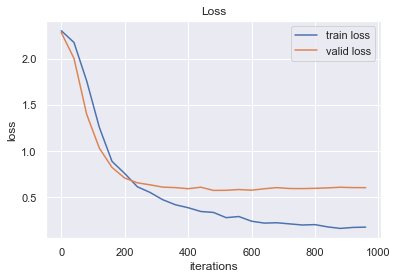

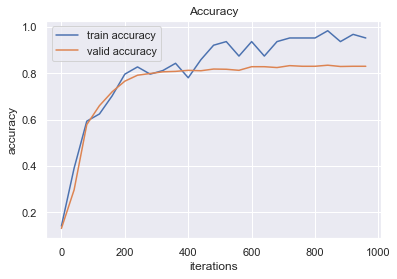

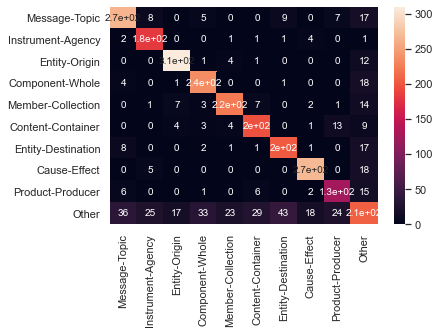

In [34]:
results_dir = 'RE-results'
test_results_file = 'results_test.pkl'
train_results_file = 'results_10_epochs_last_train.pkl'
report_results(
    results_dir, train_results_file, eval_interval,
    test_results_file=test_results_file,
    class_mapping=train_label_dict,
)